<a href="https://colab.research.google.com/github/theostoican/Guided-Research/blob/main/K_Means_on_top_of_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# !pip install pytorch_pretrained_vit
# from pytorch_pretrained_vit import ViT
# model = ViT('B_16_imagenet1k', pretrained=True)
!pip install timm
!pip install torchvision
import timm
import requests
from torchvision import models
import torchvision.transforms as transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD


# entrypoints = torch.hub.list('google/vit', force_reload=True)
# print(entrypoints)
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 30.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [ ]:
!pip install torchinfo
from torchinfo import summary
# summary(vitb16, (1, 3, 224, 224))
model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate=none)
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (ls2): 

In [ ]:
!pip install transformers
from transformers import ViTFeatureExtractor
from PIL import Image
from torchvision import transforms as pth_transforms
import os
import torchvision

feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vitb16')
def process_input(image):
  patch_size = 16

  transform = pth_transforms.Compose([
          pth_transforms.Resize((224, 224)),
          pth_transforms.ToTensor(),
          pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ])
  image = transform(image)

  w, h = image.shape[1] - image.shape[1] % patch_size, image.shape[2] - image.shape[2] % patch_size
  image = image[:, :w, :h].unsqueeze(0).to(device)

  return image


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 25.7 MB/s 
     |████████████████████████████████| 6.6 MB 52.1 MB/s 
     |████████████████████████████████| 120 kB 53.8 MB/s 


In [ ]:
img = Image.open('baseballglove1.jpg')
img = img.convert('RGB')

input = process_input(img)

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.norm.register_forward_hook(get_activation('attn'))

model(input).shape

torch.Size([1, 1000])

In [ ]:
features = activation['attn'][0][1:]
features.shape

torch.Size([196, 768])

In [ ]:
import matplotlib.pyplot as plt
# from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
num_pixels, num_channels = features.shape

In [ ]:
kmeans = KMeans(
    init="random",
    n_clusters=2,
    n_init=10,
    max_iter=1000,
    random_state=42)

In [ ]:
labels = kmeans.fit_predict(features)
print(labels.shape)
labels = labels.reshape(1, 14, 14)
print(torch.FloatTensor(labels).shape)

from torch import nn
labels = nn.functional.interpolate(torch.FloatTensor(labels).unsqueeze(0), scale_factor=16, mode="nearest")[0][0].cpu().numpy()
print(labels.shape)

NameError: ignored

In [ ]:
import numpy as np
print(np.min(labels), np.max(labels))
print(np.argmin(labels), np.argmax(labels))

0.0 1.0
0 16


In [ ]:
plt.style.use('fivethirtyeight')

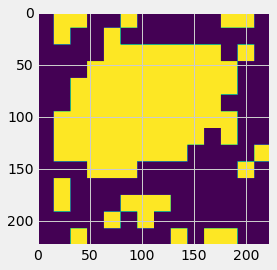

In [ ]:
plt.imshow(labels)